In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('Data/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [8]:
# Under sampling to handel imbalance data

df_spam = df[df['Category']=='spam']

df_ham = df[df['Category']=='ham']
df_ham.shape
df_ham_downsample = df_ham.sample(df_spam.shape[0])


df_spam.shape, df_ham_downsample.shape

((747, 2), (747, 2))

In [10]:
df_balanced = pd.concat([df_spam, df_ham_downsample])
df_balanced.shape

(1494, 2)

In [11]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [14]:
df_balanced.sample(5)

,Category,Message
1173,ham,Happy new years melody!
1781,spam,BIG BROTHER ALERT! The computer has selected u...
1441,ham,Cool breeze... Bright sun... Fresh flower... T...
203,ham,Your account has been refilled successfully by...
1399,ham,No did you check? I got his detailed message now


In [17]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x =='spam' else 0)

In [19]:
df_balanced.sample(5)

,Category,Message,spam
823,spam,"SMSSERVICES. for yourinclusive text credits, p...",1
851,ham,U reach orchard already? U wan 2 go buy ticket...,0
160,spam,You are a winner U have been specially selecte...,1
3828,spam,Congratulations U can claim 2 VIP row A Ticket...,1
1172,spam,Got what it takes 2 take part in the WRC Rally...,1


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [21]:
X_train.head()

2573    The house is on the water with a dock, a boat ...
1163    Free entry in 2 a wkly comp to win FA Cup fina...
1120    Bored of speed dating? Try SPEEDCHAT, txt SPEE...
3689                           I'll meet you in the lobby
2146    Sunshine Hols. To claim ur med holiday send a ...
Name: Message, dtype: object

In [22]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [23]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [24]:
get_sentence_embedding([
    'The house is on the water with a dock',
    "I'll meet you in the lobby",
    'I love you Nishu'
])

<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.88353497, -0.20798926, -0.03419311, ...,  0.00590114,
        -0.58766824,  0.9240191 ],
       [-0.8759218 , -0.19461296, -0.15719081, ..., -0.07320428,
        -0.6252252 ,  0.9392338 ],
       [-0.9085815 , -0.47692683, -0.7572337 , ..., -0.40943635,
        -0.7385911 ,  0.9035303 ]], dtype=float32)>

In [26]:
e = get_sentence_embedding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [27]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76071954, -0.14222385,  0.49599463, ...,  0.4215405 ,
        -0.53218514,  0.80314916],
       [-0.86038685, -0.21262017,  0.49019018, ...,  0.39687657,
        -0.6052787 ,  0.8448607 ],
       [-0.71292734, -0.15472871,  0.3831082 , ...,  0.35231316,
        -0.51005566,  0.7348722 ],
       [-0.8254045 , -0.35560212, -0.5906005 , ..., -0.01563795,
        -0.61412346,  0.8723322 ],
       [-0.7502036 , -0.268037  , -0.267203  , ...,  0.02813728,
        -0.5936459 ,  0.7974844 ],
       [-0.78568745, -0.2996764 ,  0.41004923, ...,  0.5222164 ,
        -0.49591416,  0.81539726]], dtype=float32)>

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]], [e[2]])

array([[0.9954065]], dtype=float32)

In [35]:
# Creating Functional Model
# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

#Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(output['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [37]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [38]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 18s 329ms/step - loss: 0.6210 - accuracy: 0.6750 - precision: 0.6672 - recall: 0.6982
Epoch 2/10
35/35 [==============================] - 11s 329ms/step - loss: 0.5140 - accuracy: 0.8009 - precision: 0.7822 - recall: 0.8339
Epoch 3/10
35/35 [==============================] - 12s 330ms/step - loss: 0.4441 - accuracy: 0.8464 - precision: 0.8380 - recall: 0.8589
Epoch 4/10
35/35 [==============================] - 12s 330ms/step - loss: 0.4025 - accuracy: 0.8589 - precision: 0.8466 - recall: 0.8768
Epoch 5/10
35/35 [==============================] - 12s 332ms/step - loss: 0.3773 - accuracy: 0.8705 - precision: 0.8476 - recall: 0.9036
Epoch 6/10
35/35 [==============================] - 12s 333ms/step - loss: 0.3422 - accuracy: 0.8920 - precision: 0.8752 - recall: 0.9143
Epoch 7/10
35/35 [==============================] - 12s 332ms/step - loss: 0.3297 - accuracy: 0.8929 - precision: 0.8767 - recall: 0.9143
Epoch 8/10
35/35 [================

In [39]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 323ms/step - loss: 0.2639 - accuracy: 0.9225 - precision: 0.9247 - recall: 0.9198


[0.2638983428478241,
 0.9224599003791809,
 0.9247311949729919,
 0.9197860956192017]

In [40]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

12/12 [==============================] - 4s 333ms/step


In [42]:
y_predicted = np.where(y_pred>0.5,1,0)
y_predicted

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[173,  14],
       [ 15, 172]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

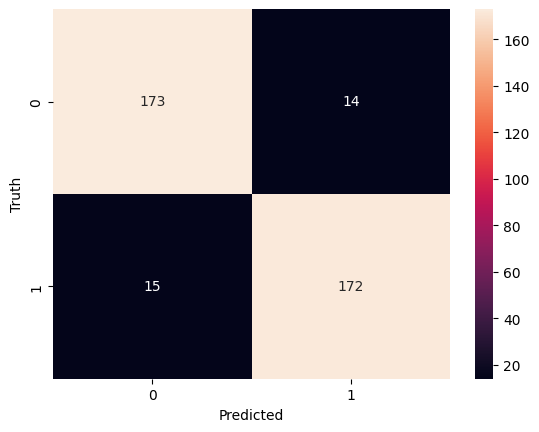

In [46]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [47]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       187
           1       0.92      0.92      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [48]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 706ms/step


array([[0.7835623 ],
       [0.8503467 ],
       [0.8018636 ],
       [0.17408071],
       [0.10265795]], dtype=float32)

In [ ]:
# First 3 looks like spam